In [1]:
from __future__ import print_function, division
from random import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
plt.ion()
torch.cuda.empty_cache()

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataL[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            else:
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss, val_acc, train_loss, train_acc

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5,5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

--------------------------------
FOLD 0
--------------------------------
Epoch 0/9
----------
train Loss: 0.8266 Acc: 0.7180
val Loss: 0.6051 Acc: 0.7022

Epoch 1/9
----------
train Loss: 0.4876 Acc: 0.7993
val Loss: 0.4253 Acc: 0.8417

Epoch 2/9
----------
train Loss: 0.4226 Acc: 0.8414
val Loss: 0.3835 Acc: 0.8511

Epoch 3/9
----------
train Loss: 0.4119 Acc: 0.8400
val Loss: 0.3645 Acc: 0.8518

Epoch 4/9
----------
train Loss: 0.3786 Acc: 0.8539
val Loss: 0.4125 Acc: 0.8266

Epoch 5/9
----------
train Loss: 0.3770 Acc: 0.8566
val Loss: 0.3461 Acc: 0.8576

Epoch 6/9
----------
train Loss: 0.3661 Acc: 0.8548
val Loss: 0.3289 Acc: 0.8604

Epoch 7/9
----------
train Loss: 0.3100 Acc: 0.8805
val Loss: 0.2974 Acc: 0.8827

Epoch 8/9
----------
train Loss: 0.2865 Acc: 0.8861
val Loss: 0.2743 Acc: 0.8914

Epoch 9/9
----------
train Loss: 0.2648 Acc: 0.8943
val Loss: 0.2600 Acc: 0.8964

Training complete in 27m 19s
Best val Acc: 0.896403
Fold Completed. Saving Model.
-------------------------

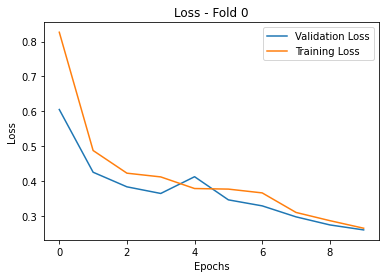

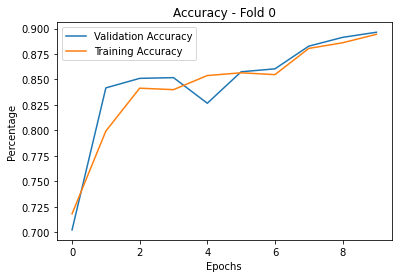

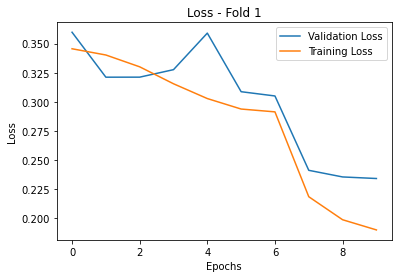

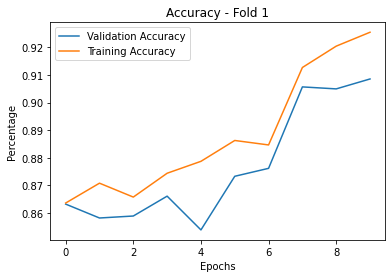

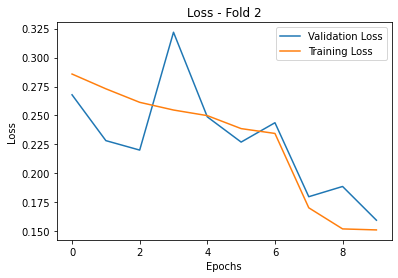

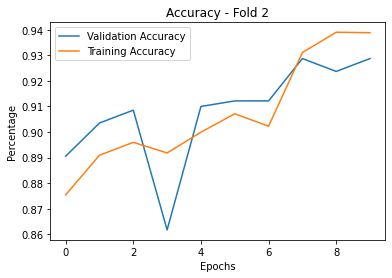

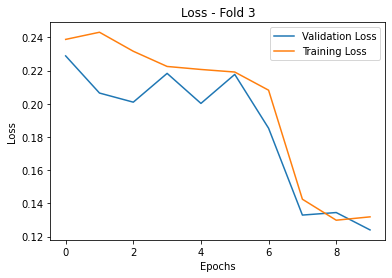

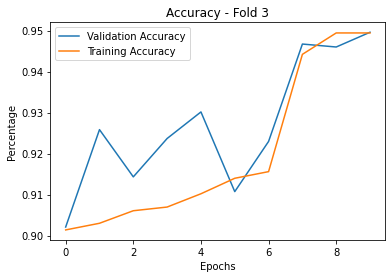

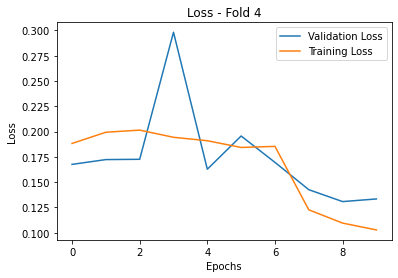

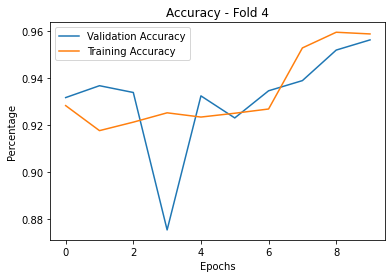

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

if __name__ == "__main__":
    
    # note: i did not use randomresized crop first as some data typically have a black circle encompassing
    # the slides from the microscope. To normalize this, I cropped around the center. - Kris
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    # DATA DIRECTORY
    data_dir = 'C:\\Users\\Kris\\..vs code files\\senior design\\images\\data-final'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    # dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
    #                                              shuffle=True, num_workers=4)
    #               for x in ['train', 'val']}
    
    
    
    dataset = ConcatDataset([image_datasets['train'], image_datasets['val']])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Make a grid from batch   
    
    model_ft = models.vgg16(pretrained=True)
    model_ft = model_ft.to(device)
    
    k_folds = 5
    fold_res = {}
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    
    # Start print
    print('--------------------------------')
    
    #K-fold Cross Validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        
        dataL = {}
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        dataL = {x: torch.utils.data.DataLoader(
            dataset,
            batch_size = 4, num_workers = 4,
            sampler=train_subsampler)
                        for x in ['train']}
        dataL['val'] = torch.utils.data.DataLoader(
            dataset,
            batch_size = 4, num_workers = 4,
            sampler=val_subsampler)
        
        dataset_sizes = {x: len(train_subsampler)
                         for x in ['train']}
        dataset_sizes['val'] = len(val_subsampler)
        
        inputs, classes = next(iter(dataL['train']))
        class_names = image_datasets['train'].classes
        out = torchvision.utils.make_grid(inputs)
        
        criterion = nn.CrossEntropyLoss()
    
        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        
        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        num_epochs = 10
        
        model_ft, vl, va, tl, ta = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)
        
        # Fold Finished
        print('Fold Completed. Saving Model.')
        print('--------------------------------')
        
        va = [x.item() for x in va]
        ta = [x.item() for x in ta]
        
        out_data = pd.DataFrame([vl, va, tl, ta])
        out_data = out_data.T
        out_data.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc']
        out_data.to_csv(f"C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-26_vgg_training_data-Fold{fold}.txt", sep = '\t', index = False)
        
        torch.save(model_ft,f"C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\model\\4-26_vgg_model-Fold{fold}.pt")
        torch.save(model_ft.state_dict(),f"C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\model\\4-26_vgg_model_state_dict-Fold{fold}.pt")
    
        x = np.arange(num_epochs)
        plt.figure()
        plt.plot(x, vl, tl)
        plt.legend(['Validation Loss', 'Training Loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss - Fold {fold}')
        plt.savefig(f'C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-26_vgg_loss-Fold{fold}.png')
        
        plt.figure()
        plt.plot(x, va, ta)
        plt.legend(['Validation Accuracy', 'Training Accuracy'])
        plt.xlabel('Epochs')
        plt.ylabel('Percentage')
        plt.title(f'Accuracy - Fold {fold}')
        plt.savefig(f'C:\\Users\\Kris\\..vs code files\\senior design\\ML-Breat_Cancer_Classfier-master\\results\\graphs\\4-26_vgg_accuracy-Fold{fold}.png')